In [2]:
import pandas as pd
from acled_conflict_analysis import analysis
from acled_conflict_analysis import visuals
import ast
import json
import geopandas as gpd
from shapely.geometry import Point
#import dask_geopandas as dgpd
import dask.dataframe as dd

import glob

# Air Pollution in Ethiopia

In [3]:
ethiopia_adm1 = gpd.read_file('../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp')
ethiopia_adm2 = gpd.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')

In [ ]:
def get_annual_baseline(df, group_column='ADM1_EN', baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year
    baseline_column = f'baseline_NO2_{baseline_year}'
    column_name = f'percent_change_NO2_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute annual baseline NO2 for the specified baseline year
        
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_column)['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column], how='left')    

    # Compute the annual percentage change
        df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's annual baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_column)['NO2']
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, group_column].map(baseline_df)

            df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    

    return df


In [ ]:
def get_monthly_baseline(df, group_column, baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year
    df['month'] = df['event_date'].dt.month
    baseline_column = f'baseline_NO2_{baseline_year}'
    column_name = f'percent_change_NO2_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute monthly NO2 baseline for the specified baseline year
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby([group_column, 'month'])['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column, 'month'], how='left')

        df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's monthly baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby([group_column, 'month'])['NO2']
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, [group_column, 'month']].apply(
                lambda row: baseline_df.get((row[group_column], row['month'])), axis=1
            )

            df[column_name] = ((df['NO2'] - df[baseline_column]) / df[baseline_column]) * 100

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    column_name = f'percent_change_NO2_{baseline_year}'

    # Compute the monthly percentage change
    

    return df


In [15]:
def clean_air_pollution(df):
    if 'system:index' in df.columns:
        df.drop(columns='system:index', inplace=True)

    if '.geo' in df.columns:
        df.drop(columns='.geo', inplace=True)
    
    if 'admin0Name' in df.columns:
        df.rename(columns={'admin0Name':'ADM0_EN', 'admin1Name':'ADM1_EN', 'admin2Name':'ADM2_EN'}, inplace=True)
        
    #df = df[['ADM0_EN', 'ADM1_EN', 'date','mean']]

    df.rename(columns={'date':'event_date', 'mean':'mean_NO2', 'NO2_column_number_density':'NO2', 'startMonth':'event_date'}, inplace=True)
    df['event_date'] = pd.to_datetime(df['event_date'])

    

In [16]:
def match_raw_file_columns(df):
    if 'ADM1_EN' in df.columns or 'ADM0_EN' in df.columns:
        df.rename(columns={'ADM0_EN':'admin0Name', 'ADM1_EN':'admin1Name', 'mean':'NO2'}, inplace=True)


In [17]:
#air_pollution = pd.read_csv('../../data/air_pollution/no2_ethiopia_20230101_20230103.csv')
air_pollution_monthly_adm1 = pd.concat([pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_Monthly_NO2_2019_2024.csv'),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202410.csv')),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202411.csv')),
                                        match_raw_file_columns(pd.read_csv('../../data/air_pollution/adm1/ETH_ADM1_no2_monthly_202412.csv'))])
clean_air_pollution(air_pollution_monthly_adm1)

air_pollution_monthly_adm1 = ethiopia_adm1[['ADM0_EN', 'ADM1_EN', 'geometry']].merge(air_pollution_monthly_adm1[['ADM0_EN', 'ADM1_EN', 'event_date','NO2']], on =['ADM0_EN','ADM1_EN'])

In [18]:
air_pollution_annual_adm1 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM1_EN'])['NO2'].mean().reset_index()
air_pollution_annual_adm1 = get_annual_baseline(air_pollution_annual_adm1, baseline_year=2019, group_column='ADM1_EN')
air_pollution_annual_adm1 = get_annual_baseline(air_pollution_annual_adm1, baseline_year='PY', group_column='ADM1_EN')

air_pollution_monthly_adm1 = get_monthly_baseline(air_pollution_monthly_adm1, baseline_year=2019, group_column='ADM1_EN')
air_pollution_monthly_adm1 = get_monthly_baseline(air_pollution_monthly_adm1, baseline_year='PY', group_column='ADM1_EN')

In [19]:
air_pollution_annual_adm0 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM0_EN'])['NO2'].mean().reset_index()
air_pollution_monthly_adm0 = air_pollution_monthly_adm1.groupby([pd.Grouper(key='event_date', freq='MS'), 'ADM0_EN'])['NO2'].mean().reset_index()

air_pollution_annual_adm0 = get_annual_baseline(air_pollution_annual_adm0, baseline_year=2019, group_column='ADM0_EN')
air_pollution_annual_adm0 = get_annual_baseline(air_pollution_annual_adm0, baseline_year='PY', group_column='ADM0_EN')

air_pollution_monthly_adm0 = get_monthly_baseline(air_pollution_monthly_adm0, baseline_year=2019, group_column='ADM0_EN')
air_pollution_monthly_adm0 = get_monthly_baseline(air_pollution_monthly_adm0, baseline_year='PY', group_column='ADM0_EN')

## National pollution trends

In [20]:
air_pollution_monthly_adm2 = pd.concat([pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2019_2021.csv'),
                                        pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2022_2023.csv'),
                                        pd.read_csv('../../data/air_pollution/adm2/ETH_ADM2_Monthly_NO2_2024_2024.csv')])

clean_air_pollution(air_pollution_monthly_adm2)
air_pollution_monthly_adm2 = ethiopia_adm2[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']].merge(air_pollution_monthly_adm2, on = ['ADM0_EN', 'ADM1_EN', 'ADM2_EN'])

In [12]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm0

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year
yearly_avg = df.groupby('year')['NO2'].mean().reset_index()

tabs = []
labels = ['Monthly National Air Pollution', '% Change in Air Pollution compared to 2019', '% Change in Air Pollution Compared to Previous Year']

for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM0_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm0['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm0[measure], 
        line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [13]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm1

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Monthly Regional Air Pollution', '% Change in Regional Air Pollution compared to 2019', '% Change in Regional Air Pollution Compared to Previous Year']


for idx, measure in enumerate(['NO2', 'percent_change_NO2_2019', 'percent_change_NO2_PY']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM1_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [14]:
air_pollution_annual_adm2 = air_pollution_monthly_adm2.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM2_EN'])['NO2'].mean().reset_index()
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year=2019, group_column='ADM2_EN')
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year='PY', group_column='ADM2_EN')

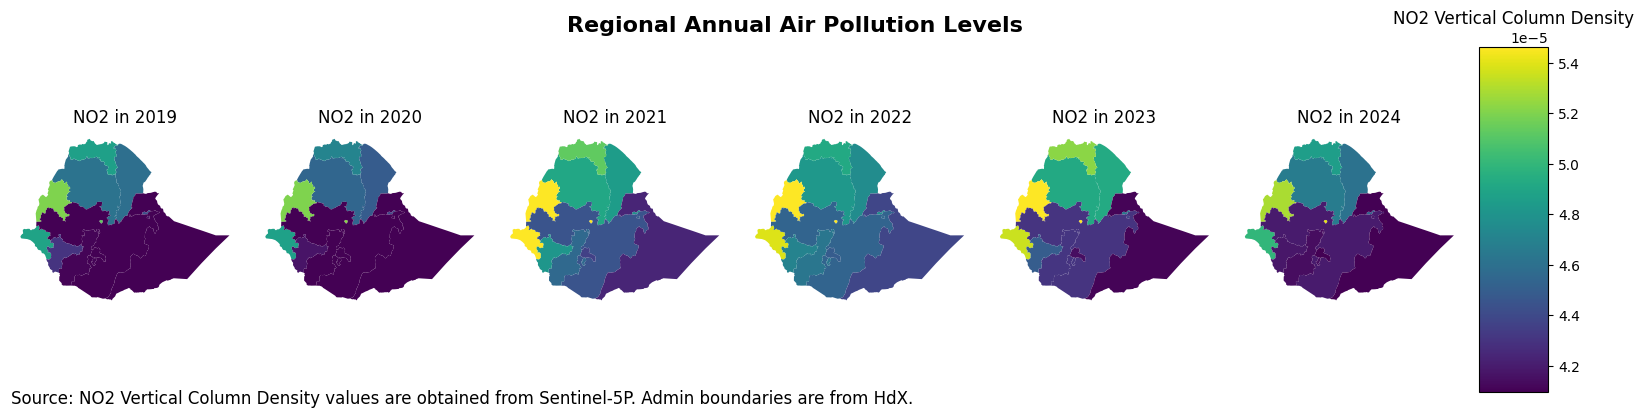

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# List of years you want to plot
years = [2019,2020,2021,2022,2023,2024]  # You can extend this to more years if needed

# Create a 2x2 grid for the plots
fig, ax = plt.subplots(1, 7, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.3]})

# # Flatten the axes array to make it easier to index
ax = ax.flatten()

vmin = air_pollution_annual_adm1.groupby(['ADM1_EN'])[['NO2']].mean().reset_index()['NO2'].min()
vmax = air_pollution_annual_adm1.groupby(['ADM1_EN'])[['NO2']].mean().reset_index()['NO2'].max()
cmap = 'viridis'

# Loop through each year and create a plot in a 2x2 grid
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm1[(air_pollution_annual_adm1['event_date'] >= start_date) & (air_pollution_annual_adm1['event_date'] <= end_date)] \
            .groupby(['ADM1_EN'])['NO2'].mean().reset_index()
    #print(df.shape)

    # Convert to GeoDataFrame and plot for each year
    ethiopia_adm1[['ADM1_EN', 'geometry']].merge(df).plot(column='NO2', ax=ax[i], cmap='viridis', markersize=10, 
                                     vmin=vmin, vmax=vmax)

    # Set the title for each subplot
    ax[i].set_title(f'NO2 in {year}')
    
    # Remove the spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar

cbar = fig.colorbar(sm, cax=ax[-1])  
ax[-1].set_title("NO2 Vertical Column Density")

# Automatically adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.suptitle('Regional Annual Air Pollution Levels', fontsize=16, fontweight='bold')

# Add a footer text at the bottom
plt.figtext(0.01, 0.01, "Source: NO2 Vertical Column Density values are obtained from Sentinel-5P. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)


# Show the plot
plt.show()

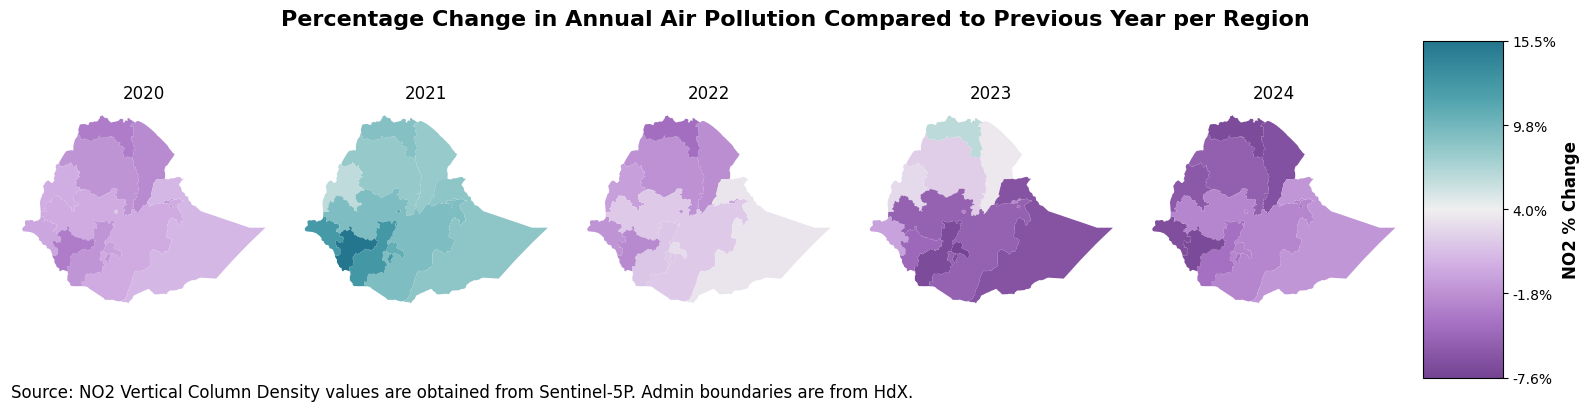

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# List of years you want to plot
years = [2020, 2021, 2022, 2023, 2024]  # You can extend this to more years if needed

# Create a figure with 6 subplots (5 maps + 1 for the legend)
fig, ax = plt.subplots(1, 6, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.3]})

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Get min and max for normalization
vmin = air_pollution_annual_adm1['percent_change_NO2_PY'].min()
vmax = air_pollution_annual_adm1['percent_change_NO2_PY'].max()

# Loop through each year and create a plot
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm1[
        (air_pollution_annual_adm1['event_date'] >= start_date) & 
        (air_pollution_annual_adm1['event_date'] <= end_date)
    ][['ADM1_EN', 'percent_change_NO2_PY']]  # Ensure correct columns are selected

    df['percent_change_NO2_PY'] = df['percent_change_NO2_PY'].astype('float64')

    # Merge with spatial data and plot for each year
    gdf = ethiopia_adm1.merge(df, on='ADM1_EN', how='left')
    im = gdf.plot(column='percent_change_NO2_PY', ax=ax[i], cmap=custom_cmap, vmin=vmin, vmax=vmax)

    # Set the title for each subplot
    ax[i].set_title(f'{year}')
    
    # Remove spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Add the colorbar (legend) in the last subplot
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar

# Create the colorbar and set percentage labels
cbar = fig.colorbar(sm, cax=ax[-1])
cbar.set_label("NO2 % Change", fontsize=12, fontweight="bold")

# Generate percentage-based tick labels
ticks = np.linspace(vmin, vmax, num=5)  # Define tick positions
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}%" for t in ticks])  # Format as percentages

# Adjust the layout so the plots don't overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.suptitle('Percentage Change in Annual Air Pollution Compared to Previous Year per Region', 
             fontsize=16, fontweight='bold')

# Add a footer text at the bottom
plt.figtext(0.01, 0.01, "Source: NO2 Vertical Column Density values are obtained from Sentinel-5P. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)

# Show the plot
plt.show()


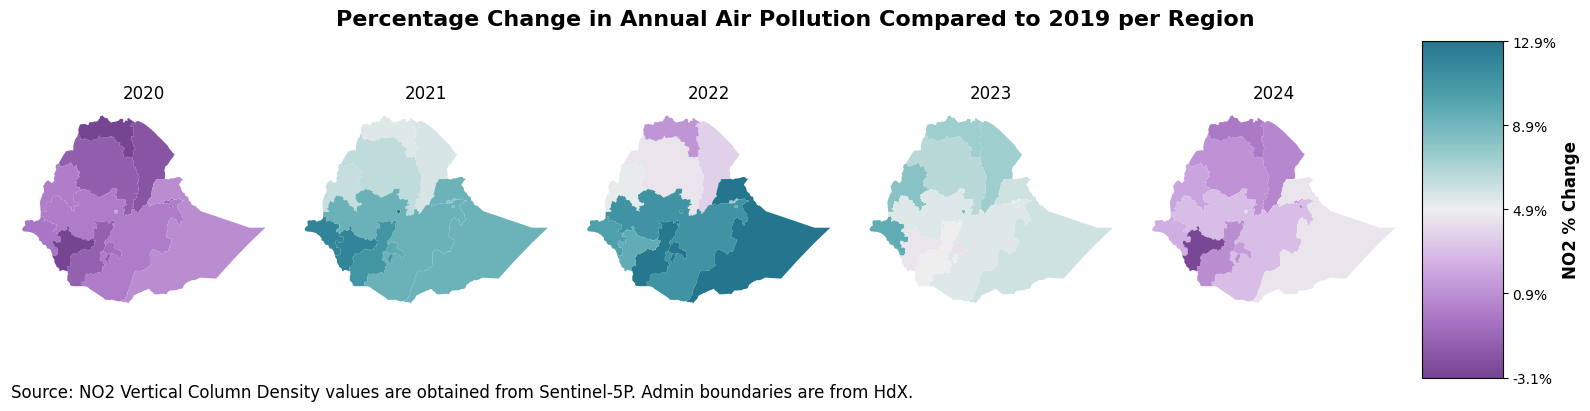

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# List of years you want to plot
years = [2020, 2021, 2022, 2023, 2024]  # You can extend this to more years if needed

# Create a figure with 6 subplots (5 maps + 1 for the legend)
fig, ax = plt.subplots(1, 6, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.3]})

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Get min and max for normalization
vmin = air_pollution_annual_adm1['percent_change_NO2_2019'].min()
vmax = air_pollution_annual_adm1['percent_change_NO2_2019'].max()

# Loop through each year and create a plot
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm1[
        (air_pollution_annual_adm1['event_date'] >= start_date) & 
        (air_pollution_annual_adm1['event_date'] <= end_date)
    ][['ADM1_EN', 'percent_change_NO2_2019']]  # Ensure correct columns are selected

    df['percent_change_NO2_2019'] = df['percent_change_NO2_2019'].astype('float64')

    # Merge with spatial data and plot for each year
    gdf = ethiopia_adm1.merge(df, on='ADM1_EN', how='left')
    im = gdf.plot(column='percent_change_NO2_2019', ax=ax[i], cmap=custom_cmap, vmin=vmin, vmax=vmax)

    # Set the title for each subplot
    ax[i].set_title(f'{year}')
    
    # Remove spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Add the colorbar (legend) in the last subplot
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar

# Create the colorbar and set percentage labels
cbar = fig.colorbar(sm, cax=ax[-1])
cbar.set_label("NO2 % Change", fontsize=12, fontweight="bold")

# Generate percentage-based tick labels
ticks = np.linspace(vmin, vmax, num=5)  # Define tick positions
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}%" for t in ticks])  # Format as percentages

# Adjust the layout so the plots don't overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.suptitle('Percentage Change in Annual Air Pollution Compared to 2019 per Region', 
             fontsize=16, fontweight='bold')

# Add a footer text at the bottom
plt.figtext(0.01, 0.01, "Source: NO2 Vertical Column Density values are obtained from Sentinel-5P. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)

# Show the plot
plt.show()


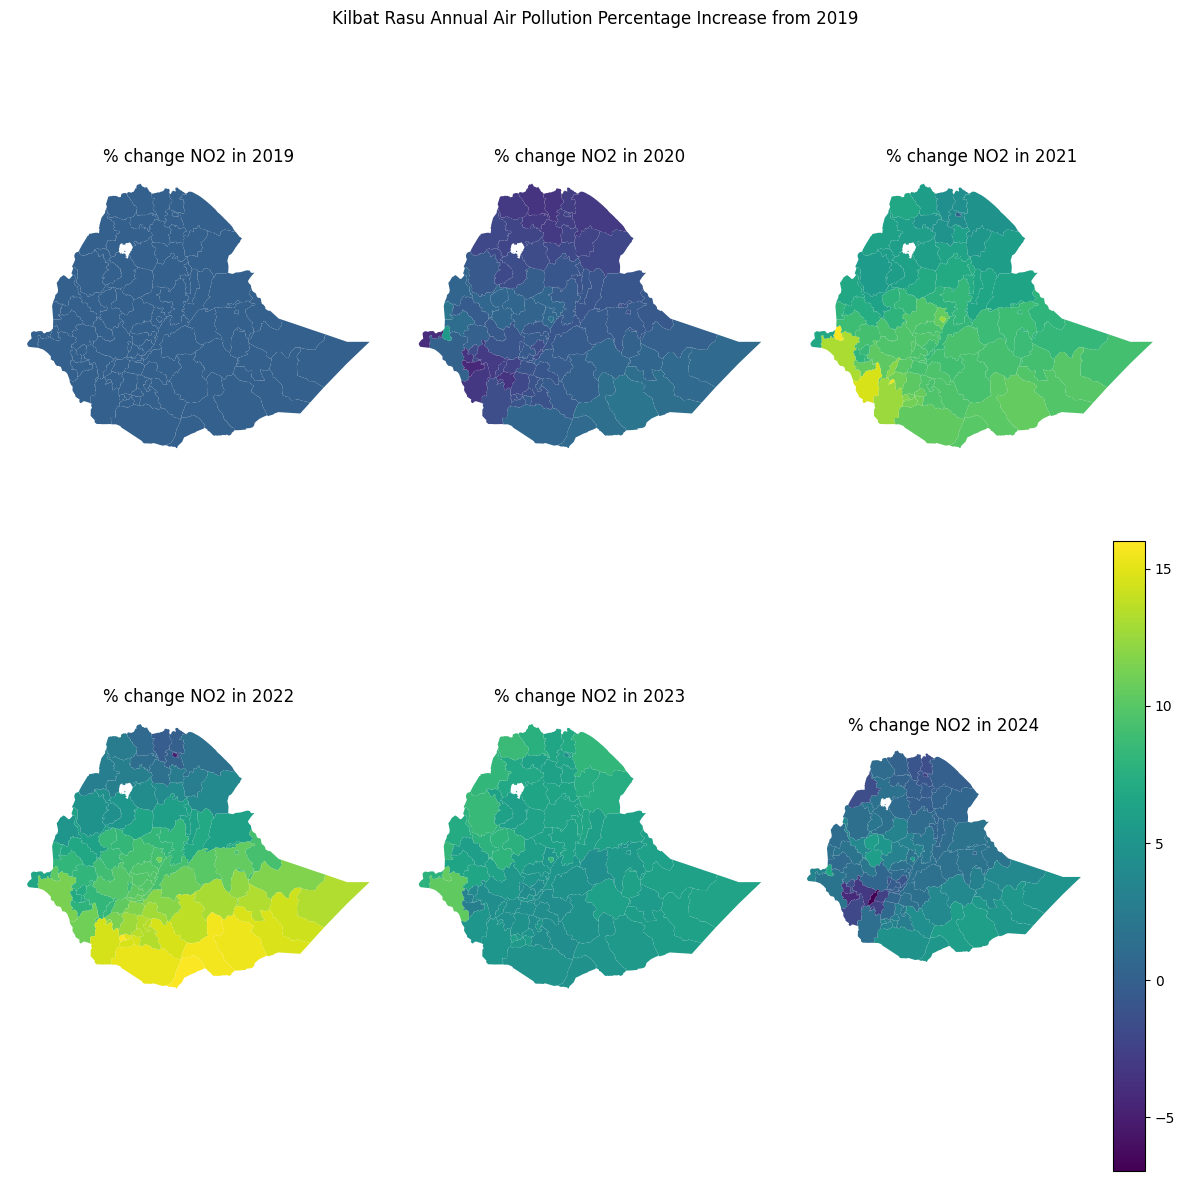

In [208]:
import matplotlib.pyplot as plt

# List of years you want to plot
years = [2019,2020,2021,2022,2023,2024]  # You can extend this to more years if needed

# Create a 2x2 grid for the plots
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# # Flatten the axes array to make it easier to index
ax = ax.flatten()

vmin = air_pollution_annual_adm2['percent_change_NO2'].min()
vmax = air_pollution_annual_adm2['percent_change_NO2'].max()

# Loop through each year and create a plot in a 2x2 grid
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm2[(air_pollution_annual_adm2['event_date'] >= start_date) & (air_pollution_annual_adm2['event_date'] <= end_date)]
    #print(df.shape)

    if i<5:
    # Convert to GeoDataFrame and plot for each year
        ethiopia_adm2[['ADM2_EN', 'geometry']].merge(df).plot(column='percent_change_NO2', ax=ax[i], cmap='viridis', markersize=10, 
                                        vmin=vmin, vmax=vmax)
    else:
        ethiopia_adm2[['ADM2_EN', 'geometry']].merge(df).plot(column='percent_change_NO2', ax=ax[i], cmap='viridis', markersize=10, 
                                        vmin=vmin, vmax=vmax, legend=True)

    # Set the title for each subplot
    ax[i].set_title(f'% change NO2 in {year}')
    
    # Remove the spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Automatically adjust the layout so the plots don't overlap
plt.tight_layout()
plt.suptitle('Kilbat Rasu Annual Air Pollution Percentage Increase from 2019')

# Show the plot
plt.show()

In [5]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Example: Load your points (these are the center points of the 1.1 km boxes)
# Replace this with your actual points GeoDataFrame
points = analysis.convert_to_gdf(air_pollution[['latitude', 'longitude']].drop_duplicates())

# Step 1: Reproject to a local UTM projection to work in meters
points_utm = points.to_crs(epsg=32633)  # Adjust UTM zone based on your region

# Step 2: Create 1.1 km x 1.1 km boxes around each center point
cell_size = 1100  # 1.1 km in meters
half_size = cell_size / 2

def create_box_around_point(point, half_size):
    """Create a 1.1 km x 1.1 km box (Polygon) around a point."""
    x, y = point.x, point.y
    return Polygon([(x - half_size, y - half_size), 
                    (x + half_size, y - half_size), 
                    (x + half_size, y + half_size), 
                    (x - half_size, y + half_size)])

# Apply the function to create boxes around each point
boxes = points_utm['geometry'].apply(lambda point: create_box_around_point(point, half_size))

# Step 3: Create a new GeoDataFrame with the boxes
boxes_gdf = gpd.GeoDataFrame(geometry=boxes, crs=points_utm.crs)

# Step 4: Reproject back to WGS84 if needed (optional)
boxes_wgs84 = boxes_gdf.to_crs(epsg=4326)


In [7]:
boxes_wgs84.to_file('../../data/air_pollution/ethiopia_no2_polygons.shp')